In [48]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation 
from scipy.optimize import minimize

In [70]:
class Dish:
    def __init__(self, f, dphi, r0, r1):
        self.set_params(f, dphi, r0, r1)
    def set_params(self, f, dphi, r0, r1):
        ## petal from center, upring
        points_pet = [ (4,4), (5,3), (5,2), (5,1), (0,1), (-5,1), (-5,2), (-5,3), (-4,4)]
        dphi_rad = dphi/180*np.pi
        def get_point ( petal, upright, f):
            r = r0+(upright-1)*r1
            x = r*np.sin(dphi_rad*petal)
            y = r*np.cos(dphi_rad*petal)
            z = r*r/(4*np.abs(f))
            #print (r,x,y,z,dphi_rad, petal, upright)
            #stop()
            return np.array([x,y,z])
        points_xyz = [get_point(petal, upright,f) for petal,upright in points_pet]
        self.points_xyz = points_xyz
        self.focal = np.array([0,0,f])
        self.dishcenter = get_point(0,3,f)

class Horn:
    def __init__(self, Dish, alpha, beta, gamma, xp, yp, zp):
        self.Dish = Dish
        self.set_params(alpha,beta,gamma, xp, yp, zp )
    def set_params(self,alpha,beta,gamma, xp, yp, zp):
        dh = 69.0
        dv = 69.1
        ## lookin down from the focal point
        p1 = np.array([-dh/2,+dv/2,0]) #corners of the horn
        p2 = np.array([+dh/2,+dv/2,0])
        p3 = np.array([+dh/2,-dv/2,0])
        p4 = np.array([-dh/2,-dv/2,0])
        R = Rotation.from_euler('zyx',[alpha,beta,gamma],degrees=True).as_matrix()   # rotates it by an angle
        ofs = np.array([xp,yp,zp])
        points_pxyz = [np.dot(R,p)+ofs for p in [p1,p2,p3,p4]]
        # points_pxyz is in the coordinate system looking down from the focal 
        # point of the dish at the center of the dish surface
        # we now need to transform this to the dish coordinate system
        znormal = self.Dish.dishcenter-self.Dish.focal
        znormal /= np.sqrt((znormal**2).sum())
        xnormal = np.array([1,0,0])
        ynormal = np.cross(xnormal,znormal)
#         print (xnormal, ynormal, znormal)
        points_xyz = [self.Dish.focal+v[0]*xnormal+v[1]*ynormal+v[2]*znormal for v in points_pxyz]
#         print (points_xyz)
        self.points = points_xyz
        
class Fitter:
    def __init__(self, data, vec):
        self.data = data
        self.vec = vec
        
    def predict_measurements(self, vec):
        D = Dish(*vec[:4])
        pD = D.points_xyz
        H = Horn(D, *vec[4:])
        pH = H.points
        def dist(p1,p2):
            return np.sqrt(np.sum((p1-p2)**2))
        pred = np.array([[dist(p1,p2) for p1 in pH] for p2 in pD])
        return pred
        
    def chi2(self, vec):
        pred = self.predict_measurements(vec)
        dchisq = (pred-self.data)**2/sigma**2
        dchisq[self.data  < 0] = 0.0 # negative numbers won't add to chi2
        chisq = dchisq.sum()
        return chisq

    def fit(self):
        fit_min = minimize(self.chi2, self.vec)
        return fit_min

In [50]:
N_measurements = np.array([
    [376.6, 337.0, 353.2, 390.8],
    [331.3, 291.8, 284.1, 324.1],
    [296.7, 269.2, 240.1, 269.5],
    [282.3, 271.1, 222.5, 235.6],    
    [272.5, 272.7, 228.3, 227.9],
    [270.0, 282.0, 236.5, 221.7],
    [266.7, 293.8, 269.4, 238.3],
    [288.3, 327.1, 323.1, 283.3],
    [333.7, 372.1, 389.4, 353.0]
])

In [51]:
# f, dphi, r0, r1, alpha, beta, gamma, xp, yp, zp
start = np.array([290., 8., 70., 100., 0, 0, 0, 0, 0, 20])
sigma = 0.3 ## sigma err in cm

N_fitter = Fitter(N_measurements, start)
N_fit = N_fitter.fit()
N_fit.fun

32.48924929803589

In [52]:
N_fitter.predict_measurements(N_fit.x)

array([[376.3674003 , 336.6492022 , 353.15656717, 391.20237167],
       [331.12362218, 291.62184969, 284.10902508, 324.52655989],
       [296.48000894, 269.64738048, 239.96969992, 269.77053726],
       [282.23342126, 271.70006467, 222.90372656, 235.62862781],
       [272.10820736, 272.77117995, 228.11491438, 227.32174129],
       [269.86662261, 281.93957835, 236.10920445, 221.55275801],
       [266.79404234, 294.26742756, 269.128735  , 238.7802716 ],
       [288.14561232, 327.324794  , 323.02645599, 283.25335726],
       [333.95349227, 371.95070755, 389.18640036, 353.04909061]])

Text(0, 0.5, 'residuals [cm]')

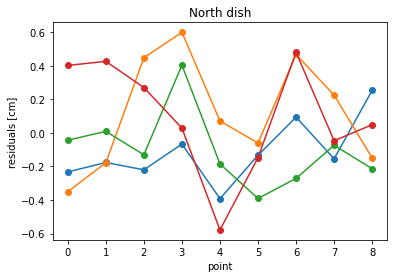

In [53]:
plt.plot(N_fitter.predict_measurements(N_fit.x)-N_measurements,'-o')
plt.title('North dish')
plt.xlabel('point')
plt.ylabel('residuals [cm]')

In [54]:
vals = N_fit.x
errs=np.sqrt((N_fit.hess_inv.diagonal())*2)
names = 'f dphi r0 r1 alpha beta gamma xp yp zp'.split()
for n,v,e in zip(names,vals, errs):
    print (f"{n} = {v:.2f} +/- {e:.2f}")

f = 288.45 +/- 5.03
dphi = 8.13 +/- 0.04
r0 = 69.57 +/- 0.45
r1 = 100.81 +/- 0.19
alpha = 1.80 +/- 0.14
beta = -0.11 +/- 0.20
gamma = 3.06 +/- 0.81
xp = -2.11 +/- 0.12
yp = -2.97 +/- 4.82
zp = 58.20 +/- 10.04


In [55]:
# E dish
E_measurements = np.array([
    [388.2, 348.8, 364.6, 401.6], 
    [341.5, 302.9, 296.0, 335.9], 
    [306.4, 278.4, 250.2, 280.9],
    [289.9, 276.8, 229.4, 245.1],
    [280.4, 277.8, 233.4, 235.7],
    [276.9, 286.0, 241.3, 229.9],
    [275.1, 299.1, 274.0, 247.1],
    [296.9, 332.4, 327.4, 291.3],
    [346.6, 381.9, 396.3, 362.7]
])

In [56]:
E_fitter = Fitter(E_measurements, N_fit.x)
E_fit = E_fitter.fit()
E_fit.fun

203.3724567030753

In [57]:
E_fitter.predict_measurements(E_fit.x)

array([[388.02726902, 349.27347351, 365.63492146, 402.81769822],
       [341.6980013 , 302.42209108, 295.87071871, 335.91350838],
       [305.93322545, 278.01458639, 249.57780571, 280.34284241],
       [289.96307463, 277.10236003, 229.07645289, 244.47676369],
       [280.15415216, 278.23419089, 233.7376043 , 236.019812  ],
       [277.05077955, 286.34116033, 240.38153125, 229.23602447],
       [275.61733951, 299.71182089, 273.98737862, 247.40013318],
       [298.02438341, 333.65207879, 328.31726724, 292.0394689 ],
       [345.07749948, 379.97230292, 395.61766001, 362.2331605 ]])

Text(0, 0.5, 'residuals [cm]')

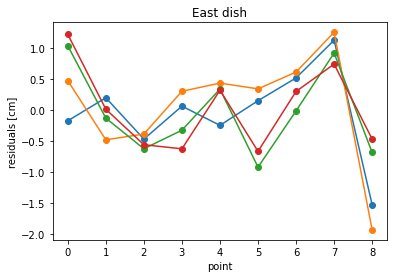

In [58]:
plt.plot(E_fitter.predict_measurements(E_fit.x)-E_measurements,'-o')
plt.title('East dish')
plt.xlabel('point')
plt.ylabel('residuals [cm]')

In [59]:
vals = E_fit.x
errs=np.sqrt((E_fit.hess_inv.diagonal())*2)
for n,v,e in zip(names,vals, errs):
    print (f"{n} = {v:.2f} +/- {e:.2f}")

f = 299.18 +/- 0.06
dphi = 7.81 +/- 0.03
r0 = 72.04 +/- 0.04
r1 = 101.43 +/- 0.05
alpha = 0.46 +/- 0.06
beta = -1.06 +/- 0.06
gamma = 0.97 +/- 0.04
xp = -5.55 +/- 0.04
yp = -8.76 +/- 0.04
zp = 57.20 +/- 0.04


In [60]:
# S dish
S_measurements = np.array([
    [384.2, 346.8, 365.9, 401.1],
    [337.5, 298.6, 295.5, 334.2],
    [302.0, 274.4, 249.9, 279.4],
    [285.3, 273.8, 229.6, 243.5],
    [276.0, 275.9, 235.4, 235.8],
    [274.2, 285.4, 243.0, 229.7],
    [275.1, 299.9, 278.9, 250.4],
    [298.7, 336.8, 334.0, 296.6],
    [347.7, 384.2, 401.3, 367.9]
])

In [61]:
S_fitter = Fitter(S_measurements, N_fit.x)
S_fit = S_fitter.fit()
S_fit.fun

67.16799833629977

In [62]:
S_fitter.predict_measurements(S_fit.x)

array([[384.2542905 , 346.41164607, 365.93138949, 401.9404347 ],
       [337.29545888, 298.88409159, 295.7909842 , 334.55766724],
       [301.39420731, 274.51472966, 249.72907289, 279.00670466],
       [285.53988749, 273.89417349, 229.16876218, 242.96775637],
       [276.4127017 , 276.08540304, 235.31169294, 235.6956188 ],
       [274.13657871, 285.25110413, 242.81655211, 229.65746092],
       [274.97127276, 300.85091036, 278.81105042, 250.66617724],
       [299.48598535, 336.58192612, 334.35420424, 296.98012783],
       [347.18034656, 383.38267497, 401.59096454, 367.18826284]])

Text(0, 0.5, 'residuals [cm]')

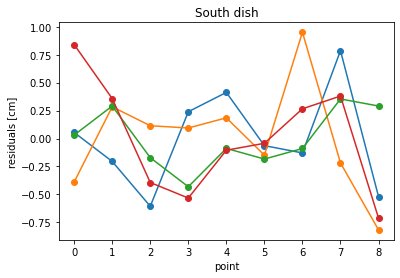

In [63]:
plt.plot(S_fitter.predict_measurements(S_fit.x)-S_measurements,'-o')
plt.title('South dish')
plt.xlabel('point')
plt.ylabel('residuals [cm]')

In [64]:
vals = S_fit.x
errs=np.sqrt((S_fit.hess_inv.diagonal())*2)
for n,v,e in zip(names,vals, errs):
    print (f"{n} = {v:.2f} +/- {e:.2f}")

f = 303.15 +/- 10.38
dphi = 7.88 +/- 0.05
r0 = 72.70 +/- 0.48
r1 = 100.77 +/- 0.31
alpha = 0.41 +/- 0.15
beta = -0.72 +/- 0.11
gamma = 3.27 +/- 0.78
xp = 0.16 +/- 0.13
yp = -14.24 +/- 4.36
zp = 58.99 +/- 9.36


In [65]:
# W dish
# numbers with minus in front of it don't contribute to chi2
W_measurements = np.array([
    [-378.1, 352.3, 371.9, 405.2],
    [-339.8, 301.7, 299.1, 336.2],
    [299.8, 273.5, 249.9, 278.1],
    [283.1, 270.8, 226.2, 241.0], # * Panel Damage
    [269.5, 269.3, 228.7, 229.9], # ** major panel-stanchion damage
    [269.9, 280.4, 237.3, 223.8],
    [271.2, 299.2, 274.7, 245.3],
    [298.0, 336.3, 332.4, 293.7],
    [348.4, 386.1, 401.4, 366.9]
])

In [71]:
W_fitter = Fitter(W_measurements, N_fit.x)
W_fit = W_fitter.fit()
W_fit.fun

221.61593551200264

In [72]:
W_fitter.predict_measurements(W_fit.x)

array([[387.26657603, 352.41090415, 371.63492564, 404.8388241 ],
       [338.81813636, 302.06123018, 300.05012108, 337.02643503],
       [299.724503  , 272.83226451, 249.09668442, 278.29209714],
       [282.80398152, 269.70027566, 224.71417061, 240.28381498],
       [271.44483497, 270.88218164, 229.41539011, 230.07947175],
       [269.42581775, 281.17168518, 237.66603994, 223.64682261],
       [270.62706797, 297.71273294, 274.77619711, 245.16952719],
       [298.31864618, 336.61931394, 333.08705726, 294.32709671],
       [348.16205703, 385.73632146, 401.77692172, 365.85380016]])

Text(0, 0.5, 'residuals [cm]')

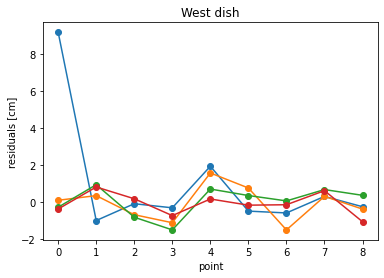

In [73]:
plt.plot(W_fitter.predict_measurements(W_fit.x)-np.abs(W_measurements),'-o')
plt.title('West dish')
plt.xlabel('point')
plt.ylabel('residuals [cm]')

In [74]:
vals = W_fit.x
errs=np.sqrt((W_fit.hess_inv.diagonal())*2)
for n,v,e in zip(names,vals, errs):
    print (f"{n} = {v:.2f} +/- {e:.2f}")

f = 378.50 +/- 0.56
dphi = 7.51 +/- 0.08
r0 = 81.54 +/- 1.95
r1 = 101.62 +/- 0.15
alpha = -1.38 +/- 0.17
beta = 1.44 +/- 0.12
gamma = -3.35 +/- 0.10
xp = -3.52 +/- 0.13
yp = -46.82 +/- 0.74
zp = 131.14 +/- 0.19
